In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler


In [4]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: '+device_name)
device = torch.device(device_name)


Using device: cpu


In [5]:
df = pd.read_csv('justin_clean_airquality.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)


In [6]:
pollutant_cols = ['NO2(GT)', 'NOx(GT)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
available_pollutants = [col for col in pollutant_cols if col in df.columns]


In [7]:
feature_cols = ['hour', 'day_of_week', 'month', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']
feature_cols = [col for col in feature_cols if col in df.columns]
X = df[feature_cols].values

y = df['AQI_next_hour'].values.reshape(-1, 1)


In [8]:

total_samples = X.shape[0]
train_size = int(0.8 * total_samples)

X_train_raw, X_test_raw = X[:train_size], X[train_size:]
y_train_raw, y_test_raw = y[:train_size], y[train_size:]

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)
y_train = scaler_y.fit_transform(y_train_raw)
y_test = scaler_y.transform(y_test_raw)


In [9]:
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()

batch_size = 64
ds_train = TensorDataset(X_train_tensor, y_train_tensor)
ds_test = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)


In [10]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, activation='relu'):
        super().__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)


In [11]:
input_size = X_train.shape[1]
EPOCHS = 50

configs = [
    {'hidden_sizes': [64], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001},
    {'hidden_sizes': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001},
    {'hidden_sizes': [256, 128, 64], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001},
    {'hidden_sizes': [128, 64], 'activation': 'tanh', 'optimizer': 'adam', 'lr': 0.001},
    {'hidden_sizes': [128, 64], 'activation': 'sigmoid', 'optimizer': 'adam', 'lr': 0.001},
    {'hidden_sizes': [128, 64], 'activation': 'relu', 'optimizer': 'sgd', 'lr': 0.01},
    {'hidden_sizes': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.0001},
]

results = []


In [12]:
for config_idx, config in enumerate(configs):
    model = MLP(input_size, config['hidden_sizes'], config['activation']).to(device)
    criterion = nn.MSELoss()
    
    if config['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'])
    
    train_losses = []
    test_losses = []
    
    for epoch in range(1, EPOCHS + 1):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                test_loss += criterion(pred, yb).item() * xb.size(0)
        
        n_train, n_test = len(train_loader.dataset), len(test_loader.dataset)
        train_losses.append(train_loss/n_train)
        test_losses.append(test_loss/n_test)
        
        if epoch % 10 == 0:
            print(f"Config {config_idx+1} | Epoch {epoch:03d} | train MSE: {train_loss/n_train:.6f} | test MSE: {test_loss/n_test:.6f}")
    
    final_test_loss = test_losses[-1]
    results.append({
        'config': config,
        'final_test_mse': final_test_loss,
        'train_losses': train_losses,
        'test_losses': test_losses
    })
    print(f"Config {config_idx+1} completed. Final test MSE: {final_test_loss:.6f}\n")


Config 1 | Epoch 010 | train MSE: 0.220943 | test MSE: 0.241791
Config 1 | Epoch 020 | train MSE: 0.214039 | test MSE: 0.236745
Config 1 | Epoch 030 | train MSE: 0.211327 | test MSE: 0.238660
Config 1 | Epoch 040 | train MSE: 0.204612 | test MSE: 0.234690
Config 1 | Epoch 050 | train MSE: 0.193447 | test MSE: 0.244154
Config 1 completed. Final test MSE: 0.244154

Config 2 | Epoch 010 | train MSE: 0.195902 | test MSE: 0.219759
Config 2 | Epoch 020 | train MSE: 0.179302 | test MSE: 0.227669
Config 2 | Epoch 030 | train MSE: 0.169397 | test MSE: 0.214181
Config 2 | Epoch 040 | train MSE: 0.162819 | test MSE: 0.207204
Config 2 | Epoch 050 | train MSE: 0.153351 | test MSE: 0.255803
Config 2 completed. Final test MSE: 0.255803

Config 3 | Epoch 010 | train MSE: 0.181016 | test MSE: 0.210664
Config 3 | Epoch 020 | train MSE: 0.159255 | test MSE: 0.195139
Config 3 | Epoch 030 | train MSE: 0.146160 | test MSE: 0.227245
Config 3 | Epoch 040 | train MSE: 0.142343 | test MSE: 0.197664
Config 3 | E

In [13]:
best_config_idx = np.argmin([r['final_test_mse'] for r in results])
best_result = results[best_config_idx]
print(f"Best configuration: {best_result['config']}")
print(f"Best test MSE: {best_result['final_test_mse']:.6f}")


Best configuration: {'hidden_sizes': [256, 128, 64], 'activation': 'relu', 'optimizer': 'adam', 'lr': 0.001}
Best test MSE: 0.196835


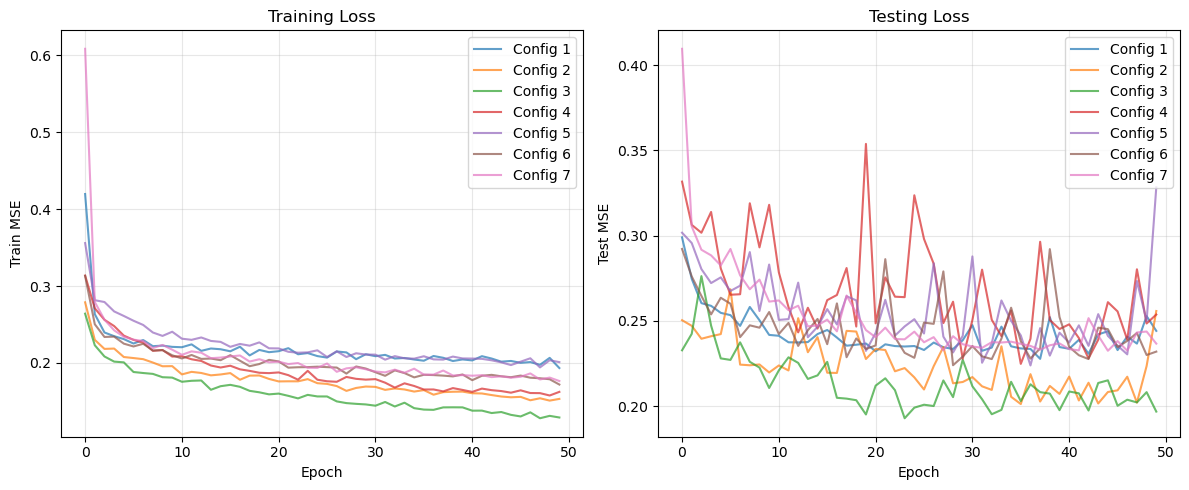

In [14]:
plt.figure(figsize=(12, 5))
for i, result in enumerate(results):
    plt.subplot(1, 2, 1)
    plt.plot(result['train_losses'], alpha=0.7, label=f"Config {i+1}")
    plt.subplot(1, 2, 2)
    plt.plot(result['test_losses'], alpha=0.7, label=f"Config {i+1}")

plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylabel('Train MSE')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylabel('Test MSE')
plt.title('Testing Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [19]:
best_model = MLP(input_size, best_result['config']['hidden_sizes'], best_result['config']['activation']).to(device)
criterion = nn.MSELoss()

if best_result['config']['optimizer'] == 'adam':
    optimizer = torch.optim.Adam(best_model.parameters(), lr=best_result['config']['lr'])
else:
    optimizer = torch.optim.SGD(best_model.parameters(), lr=best_result['config']['lr'])

best_train_losses = []
best_test_losses = []

for epoch in range(1, EPOCHS + 1):
    best_model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = best_model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    n_train = len(train_loader.dataset)
    epoch_train_mse = train_loss / n_train
    best_train_losses.append(epoch_train_mse)

    best_model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = best_model(xb)
            test_loss += criterion(pred, yb).item() * xb.size(0)
    n_test = len(test_loader.dataset)
    epoch_test_mse = test_loss / n_test
    best_test_losses.append(epoch_test_mse)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | train MSE: {epoch_train_mse:.6f} | test MSE: {epoch_test_mse:.6f}")


Epoch 010 | train MSE: 0.183060 | test MSE: 0.223646
Epoch 020 | train MSE: 0.162531 | test MSE: 0.196499
Epoch 030 | train MSE: 0.147811 | test MSE: 0.195176
Epoch 040 | train MSE: 0.142768 | test MSE: 0.194959
Epoch 050 | train MSE: 0.126318 | test MSE: 0.196600


In [ ]:
best_model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = best_model(xb)
        predictions.append(pred.cpu().numpy())
        actuals.append(yb.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

predictions_unscaled = scaler_y.inverse_transform(predictions)
actuals_unscaled = scaler_y.inverse_transform(actuals)


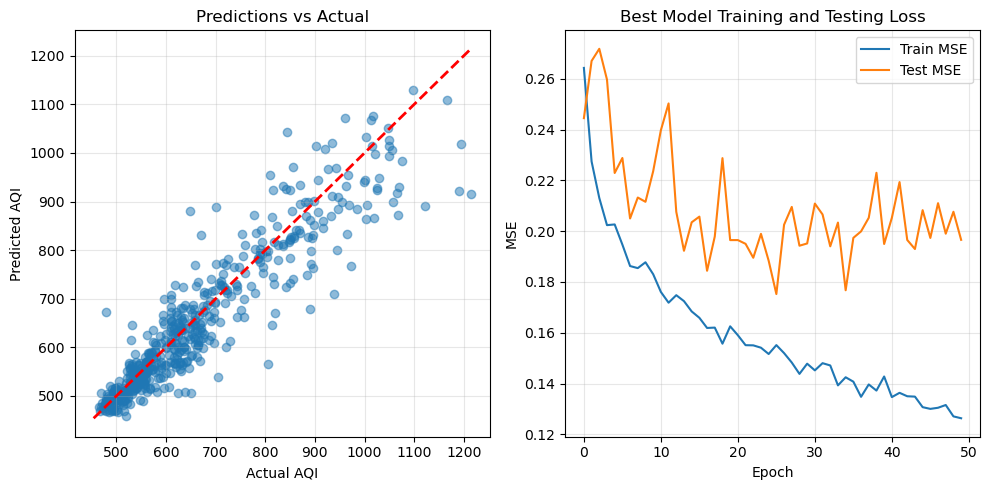

In [24]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(actuals_unscaled[:500], predictions_unscaled[:500], alpha=0.5)
plt.plot([actuals_unscaled.min(), actuals_unscaled.max()], 
         [actuals_unscaled.min(), actuals_unscaled.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Predictions vs Actual')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(best_train_losses, label='Train MSE')
plt.plot(best_test_losses, label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training and Testing Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
